In [33]:
 import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
import datetime
import pandas as pd
import random

import numpy as np
import pickle
import pydot
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import csv
from keras.utils import plot_model
from keras import optimizers
from keras.models import Sequential
from keras.layers import core, Flatten
from keras.layers.recurrent import LSTM,GRU,SimpleRNN
from keras.layers import BatchNormalization,Conv1D
# from keras import backend as K
# K.set_image_dim_ordering('tf')

In [34]:
import quandl
quandl.ApiConfig.api_key = 'ZhXAeHP_M4TuzbXSznR6'

# ENVIRONMENT_VARIABLE['quandl_api_key']

In [35]:
def get_cummulative_return(data):
    cumret  = (data / data[0]) - 1

    return cumret

In [36]:
def windowData(data, windowsize = 1, step = 1):
    # Note: this func will discard the tail of the data if they cannot fit the window fully.
    return np.array([data[i: i + windowsize] for i in range(0,(len(data)-windowsize+1), step)])

# Unit test ---------------------------------------------------------------------------------------
# data = np.array(range(20))
# print(data)
# slicedData = window(data, windowsize=4, step=2)
# print(slicedData)

In [37]:
def normalize_in_window(data):
    # Normalize data in each window
    data
    return np.array([get_cummulative_return(split) for split in data])

# # Unit test ---------------------------------------------------------------------------------------
# data = np.array(range(20))
# print(data)
# slicedData = windowData(data, windowsize=4, step=2)
# print(slicedData)
# normailzeData = normalize_in_window(slicedData)
# print(normailzeData)
    

In [41]:
def load_obj(name,path):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [42]:
def splitSingleData(data,
          window_size    = 100,
          trainpct     = 0.60,
          shift     = 1,
          normalize = False,
          predictdays = 1):
    
#     Data   = share[attrs]
    
#     data = []
#     for d in Data:
#         data.append(d)
    if trainpct < 1:
        size   = len(data)
        split  = int(np.rint(trainpct * size))

        train  = data[:split+1]
        test   = data[split+1:]    
    else:
        train = data
    
#     while (len(test)%predictdays != 0):
#         test   = test[:-1]
    
#     while (len(train)%predictdays != 0):
#         train   = train[:-1]    
    
#     length = len(data)

#     window = int(np.rint(length * window))
    
    offset = shift - 1
#     print("before",train)
    window_train = windowData(train, windowsize = window_size)
#     splits_train = np.array([train[i if i is 0 else i + offset: i + window] for i in range(0,len(train) - window)])
    if trainpct < 1:
        window_test = windowData(test, windowsize = window_size, step = predictdays)
#     splits_test = np.array([test[i if i is 0 else i + offset: i + window] for i in range(0,len(test) - window, predictdays)])

    if normalize:
        window_train = normalize_in_window(window_train)
        if trainpct < 1:
            window_test = normalize_in_window(window_test)

    
    
    Xtrain = window_train[:-window_size,:-1]
    ytrain = window_train[:, -1]
    
    if trainpct < 1:
        Xtest = window_test[::predictdays,:-1]
        ytest = window_test[:, -1] 
        temp = len(Xtest)-len(list(range(0,ytest.shape[0] - window_size, predictdays)))
        Xtest = Xtest[:-temp]

    # Chunk
    ytrain = np.array([ytrain[i:i+predictdays] for i in range(0,ytrain.shape[0] - window_size)])
    if trainpct < 1:
        ytest = np.array([ytest[i:i+predictdays] for i in range(0,ytest.shape[0] - window_size, predictdays)])

    if trainpct == 1:
        return (Xtrain, ytrain) 
    else:
        return (Xtrain, Xtest, ytrain, ytest) 

# Unit test --------------------------------------------------------------------------
# share = quandl.get("WIKI/AAPL")
# data = share["Close"]
# Xtrain,  ytrain = splitSingleData(data, trainpct = 1, normalize = False,predictdays = 3)
# print(Xtrain)
# print(Xtrain.shape)
# print(ytrain.shape)
# print(Xtest.shape)
# print(ytest.shape)
# Xtrain, Xtest, ytrain, ytest = split(share, 'Close', normalize = False)
# print(Xtrain)
# print(Xtrain.shape)
# print(ytrain.shape)

In [43]:
def create_1DCNN_1(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(Conv1D(1,3,
            input_shape = (None, 1),
            activation='relu'))
#     model.add(SimpleRNN(500, return_sequences = True))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))
    model.add(Flatten())
    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'sigmoid')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    model.summary()
    return model

In [44]:
def create_LSTM_1(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(LSTM(
            input_shape = (None, 1),
            units=128,
            return_sequences = False))
#     model.add(LSTM(200, return_sequences = True))
#     model.add(core.Dropout(0.2))
#     model.add(LSTM(100, return_sequences = False))
#     model.add(core.Dropout(0.2))
    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    plot_model(model,to_file='model22.png', show_shapes= True, show_layer_names=False)
    model.summary()
    return model

# Test Unit----------------
create_LSTM_1(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128)               66560     
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 5)                 325       
Total params: 75,141
Trainable params: 75,141
Non-trainable params: 0
_________________________________________________________________


In [45]:
def create_LSTM_2(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(LSTM(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(LSTM(64, return_sequences = True))
#     model.add(core.Dropout(0.2))
#     model.add(LSTM(64, return_sequences = False))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 
    
    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    plot_model(model,to_file='lstm.png', show_shapes= True, show_layer_names=False)
    model.summary()
    return model
# Test Unit----------------
create_LSTM_2(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, None, 128)         66560     
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
dense_33 (Dense)             (None, None, 64)          4160      
_________________________________________________________________
dense_34 (Dense)             (None, None, 5)           325       
Total params: 120,453
Trainable params: 120,453
Non-trainable params: 0
_________________________________________________________________


In [46]:
def create_LSTM_3(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(LSTM(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(LSTM(128, return_sequences = True))
#     model.add(core.Dropout(0.2))
    model.add(LSTM(64, return_sequences = False))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 
    
    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    model.summary()
    return model
    
# Test Unit ------------
create_LSTM_3(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, None, 128)         66560     
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 128)         131584    
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_35 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_36 (Dense)             (None, 5)                 325       
Total params: 252,037
Trainable params: 252,037
Non-trainable params: 0
_________________________________________________________________


In [47]:
def create_SimpleRNN_1(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(SimpleRNN(
            input_shape = (None, 1),
            units=128,
            return_sequences = False))
#     model.add(SimpleRNN(500, return_sequences = True))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    model.summary()
    
    return model
# Test Unit----------------
create_SimpleRNN_1(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_33 (SimpleRNN)    (None, 128)               16640     
_________________________________________________________________
dense_37 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_38 (Dense)             (None, 5)                 325       
Total params: 25,221
Trainable params: 25,221
Non-trainable params: 0
_________________________________________________________________


In [48]:
def create_SimpleRNN_2(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(SimpleRNN(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(SimpleRNN(64, return_sequences = False))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    plot_model(model,to_file='model22.png', show_shapes= True, show_layer_names=False)
#     model.summary()
    return model

# Test Unit----------------
create_SimpleRNN_2(5)

In [49]:
def create_SimpleRNN_3(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(SimpleRNN(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(SimpleRNN(128, return_sequences = True))
    model.add(SimpleRNN(64, return_sequences = False))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    model.summary()
    plot_model(model,to_file='model1.png', show_shapes= True, show_layer_names=False)
    return model
# Test Unit----------------
create_SimpleRNN_3(5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_36 (SimpleRNN)    (None, None, 128)         16640     
_________________________________________________________________
simple_rnn_37 (SimpleRNN)    (None, None, 128)         32896     
_________________________________________________________________
simple_rnn_38 (SimpleRNN)    (None, 64)                12352     
_________________________________________________________________
dense_41 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_42 (Dense)             (None, 5)                 325       
Total params: 66,373
Trainable params: 66,373
Non-trainable params: 0
_________________________________________________________________


In [50]:
def create_GRU_1(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(GRU(
            input_shape = (None, 1),
            units=128,
            return_sequences = False))
#     model.add(SimpleRNN(128, return_sequences = True))
#     model.add(SimpleRNN(64, return_sequences = False))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop(decay = 0.00005))
    model.summary()
    return model

In [51]:
def create_GRU_2(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(GRU(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(GRU(64, return_sequences = False))
#     model.add(SimpleRNN(64, return_sequences = False))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    model.summary()
    return model

In [52]:
def create_GRU_3(outputunits):
    
    # RNN model
    model = Sequential()
    model.add(GRU(
            input_shape = (None, 1),
            units=128,
            return_sequences = True))
    model.add(GRU(128, return_sequences = True))
    model.add(GRU(64, return_sequences = False))
# #     model.add(core.Dropout(0.2))
#     model.add(SimpleRNN(600, return_sequences = False))
#     model.add((BatchNormalization()))
#     model.add(core.Dropout(0.2))

    model.add(core.Dense(units = 64, activation = 'relu'))
    model.add(core.Dense(units = outputunits, activation = 'linear')) 

    model.compile(loss = 'mse', optimizer = optimizers.RMSprop())
    plot_model(model,to_file='GRU.png', show_shapes= True, show_layer_names=False)
    model.summary()
    return model

# Test Unit----------------
create_GRU_3(5)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, None, 128)         49920     
_________________________________________________________________
gru_5 (GRU)                  (None, None, 128)         98688     
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                37056     
_________________________________________________________________
dense_43 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 325       
Total params: 190,149
Trainable params: 190,149
Non-trainable params: 0
_________________________________________________________________


In [66]:
def stock_predict():
#     stock_data = np.load("../stock_dataset/stock_data_10.npy")
    share = quandl.get("WIKI/AAPL")
    data = share["Close"]
#     Xtrain,  ytrain = splitSingleData(data, trainpct = 1, normalize = False, predictdays = 3)
    MSE = []
    predictday = 1
#     layers      = [1, 100, 100, predictday]# number of neurons in each layer
    nbatch      = 128  
    nepoch      = 40
    nvalidation = 0.05

    learning_rate = 0.0005
    dropout    = 0.2
    activation = 'linear'
    loss = 'mse'

        
    # Xtrain, Xtest, ytrain, ytest = splitShare(share, 'Close', normalize = True,predictdays = predictday)
    Xtrain, Xtest, ytrain, ytest = splitSingleData(data, window_size = 100,  normalize = True, predictdays = predictday)

    Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], 1))
    Xtest  = np.reshape( Xtest, ( Xtest.shape[0],  Xtest.shape[1], 1))


    # Choose one model
    model = create_SimpleRNN_1(predictday)


    # Training
#     validation = (Xtest, ytest)
    hist_obj = model.fit(Xtrain, ytrain,
            batch_size       = nbatch,
            epochs         = nepoch,
            validation_split = 0.1)

    # Testing
    p = model.predict(Xtest)
    mse = mean_squared_error(ytest, p)
    MSE.append(mse)
    
    return p, ytest, MSE, hist_obj

# Test Unit ----------------------------------------------------------------------
p, ytest, MSE, hist_obj = stock_predict()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_42 (SimpleRNN)    (None, 128)               16640     
_________________________________________________________________
dense_53 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 65        
Total params: 24,961
Trainable params: 24,961
Non-trainable params: 0
_________________________________________________________________
Train on 4858 samples, validate on 540 samples
Epoch 1/40
4858/4858 [==============================] - 4s - loss: 0.0139 - val_loss: 0.0027
Epoch 2/40
4858/4858 [==============================] - 3s - loss: 0.0042 - val_loss: 0.0031
Epoch 3/40
4858/4858 [==============================] - 3s - loss: 0.0033 - val_loss: 0.0022
Epoch 4/40
4858/4858 [==============================] - 3s - loss: 0.0025 - 

In [62]:
print("Loss of prediction of Facebook with LSTM is ", MSE, r"(cell = {}, dropout = {}, activation = {}, loss = {}, optimizer = {}, epoch = {})".format('LSTM', 0.2, 'linear', 'mse', 'rmsprop', 15))

Loss of prediction of Facebook with LSTM is  [0.0012670859956486593] (cell = LSTM, dropout = 0.2, activation = linear, loss = mse, optimizer = rmsprop, epoch = 15)


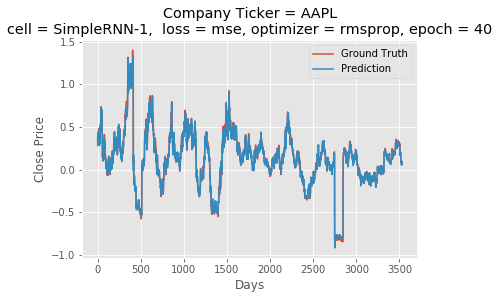

In [70]:
# # Plot predction figure
plt.style.use('ggplot')
plt.figure
plt.plot(ytest.flatten(), label="Ground Truth")
plt.plot(p.flatten(), label="Prediction")
plt.xlabel("Days")
plt.ylabel("Close Price")
plt.title(r'Company Ticker = {}'.format('AAPL')+"\n"+r'cell = {},  loss = {}, optimizer = {}, epoch = {}'.format('SimpleRNN-1','mse', 'rmsprop', 40))
plt.legend(loc='best')
# plt.savefig('predict')
plt.show()

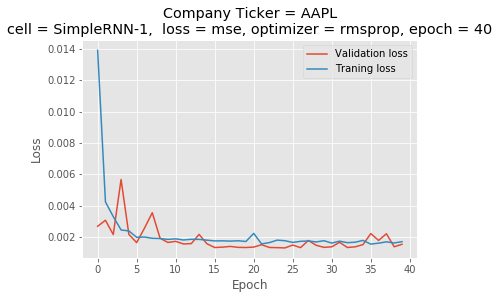

In [68]:
# # Plot loss functiom
loss = hist_obj.history
traintloss = loss['loss']
testloss = loss['val_loss']
plt.figure
plt.plot(testloss, label="Validation loss")
plt.plot(traintloss, label="Traning loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(r'Company Ticker = {}'.format('AAPL')+"\n"+r'cell = {},  loss = {}, optimizer = {}, epoch = {}'.format('SimpleRNN-1','mse', 'rmsprop', 40))
plt.legend(loc='best')
# plt.savefig('loss')
plt.show()